In [57]:
import os
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, log_loss, classification_report

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt

import re
from tqdm import tqdm

In [63]:
# Process Pokémon and one-hot encode the types

pokemon = pd.read_csv('../data/external/stats/pokemon.csv')
pokemon["Variety"] = float("NaN")
pokemon = pokemon[["#", "Name", "Variety", "Type 1", "Type 2"]]

# Create one-hot columns for each type
types = set(pokemon["Type 1"])
for t in types:
    pokemon["is" + str(t)] = 0

# Iterate over Pokémon
for i, p in pokemon.iterrows():
    
    # Clean up name
    pokemonName = pokemon.loc[i, "Name"]
    pokemonName = pokemonName.replace(" ", "")
    
    pokemonNameComponents = re.findall('[A-Z][^A-Z0-9]*', pokemonName)

    pokemon.loc[i, "Name"] = pokemonNameComponents[0]
    
    # Set variety (Mega etc.)
    if len(pokemonNameComponents) > 1:
        pokemonNameComponents = [value for value in pokemonNameComponents if value != pokemonNameComponents[0]]
        pokemon.loc[i, "Variety"] = str(pokemonNameComponents).lower()
    else:
        pokemon.loc[i, "Variety"] = "normal"
    
    #  Set one-hot columns to 1 for relevant types
    pokemon.loc[i, "is" + p["Type 1"]] = 1

#     if not pd.isna(p["Type 2"]):
#         pokemon.loc[i, "is" + p["Type 2"]] = 1

# Ditch all Pokemon with varieties (e.g. Megas):
pokemon = pokemon[pokemon["Variety"] == "normal"]


# Save output
pokemon.to_csv('../data/processed/pokemon.csv', index=False)

pokemon.head()

,#,Name,Variety,Type 1,Type 2,isFairy,isWater,isNormal,isGhost,isPsychic,...,isPoison,isFighting,isFlying,isBug,isFire,isDragon,isRock,isSteel,isIce,isElectric
0,1,Bulbasaur,normal,Grass,Poison,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Ivysaur,normal,Grass,Poison,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Venusaur,normal,Grass,Poison,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,Charmander,normal,Fire,NaN,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,5,Charmeleon,normal,Fire,NaN,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [64]:
# Process image data

data_directory_images = "../data/external/images-gen-1-6"
output_directory = "../data/processed/pokemon"

pokemon = pd.read_csv('../data/processed/pokemon.csv')
pokemon["imagePath"] = np.nan

# Remove processed folder and create empty new one
try:
    shutil.rmtree(output_directory)
    os.mkdir(output_directory)
except:
    os.mkdir(output_directory)

# Copy images to processed folder
for image in os.listdir(data_directory_images):
    pokemon_id = image.split('.')[0]

    # Images with no variety (e.g. "211.png")
    if pokemon_id.isnumeric():
        
        # Copy to processed folder
        src = data_directory_images + "/" + image
        dst = output_directory + "/" + pokemon_id + ".png"

        shutil.copyfile(src, dst)

        # Set image path in data frame
        pokemon.loc[pokemon["#"] == int(pokemon_id), 'imagePath'] = dst
        

# Drop Pokemon without image path
pokemon = pokemon.dropna(subset=["imagePath"])

# Save pokemon.csv with image paths
pokemon.to_csv('../data/processed/pokemon-with-image-paths.csv', index=False)

pokemon.head()

,#,Name,Variety,Type 1,Type 2,isFairy,isWater,isNormal,isGhost,isPsychic,...,isFighting,isFlying,isBug,isFire,isDragon,isRock,isSteel,isIce,isElectric,imagePath
0,1,Bulbasaur,normal,Grass,Poison,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,../data/processed/pokemon/1.png
1,2,Ivysaur,normal,Grass,Poison,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,../data/processed/pokemon/2.png
2,3,Venusaur,normal,Grass,Poison,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,../data/processed/pokemon/3.png
3,4,Charmander,normal,Fire,NaN,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,../data/processed/pokemon/4.png
4,5,Charmeleon,normal,Fire,NaN,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,../data/processed/pokemon/5.png


In [82]:
pokemon.sum(axis = 0, skipna = True)
uncommon = ['isFairy', 'isFlying']
pokemon_2 = pokemon[~pokemon['Type 1'].isin(uncommon)]

/var/folders/py/y149wy5x3z3cwb9vr8sptzn80000gp/T/ipykernel_11434/372423261.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pokemon.sum(axis = 0, skipna = True)


In [83]:
# Load images as training data
train_image = []

for i in tqdm(range(pokemon_2.shape[0])):
    
    img = tf.keras.utils.load_img(pokemon_2.iloc[i]["imagePath"])
    img = tf.keras.utils.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

X.shape

100%|████████████████████████████████████████| 693/693 [00:01<00:00, 500.23it/s]


(693, 256, 256, 3)

In [91]:
# Create labels

y = np.array(pokemon_2.drop(['#', 'Name', 'Variety', 'Type 1', 'Type 2', 'imagePath', 'isFairy', 'isFlying'], axis=1))

y.shape

(693, 16)

In [94]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.5, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(450, 256, 256, 3) (450, 16)
(243, 256, 256, 3) (243, 16)


In [108]:
# Create model

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(6, 6), activation="relu", input_shape=(256,256,3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.20))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.20))
model.add(Dense(16, activation='softmax'))

model.summary()

optimizer = keras.optimizers.SGD(lr=0.001) #Adam, RMSprop or SGD

model.compile(
    optimizer=optimizer
    , loss='CategoricalCrossentropy'
    , metrics=['accuracy']
)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 256, 256, 32)      3488      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 dropout_72 (Dropout)        (None, 128, 128, 32)      0         
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 dropout_73 (Dropout)        (None, 64, 64, 64)      

/Users/almaliezenga/Documents/example-pokemon-classifier/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20


2022-07-19 22:21:31.193172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 2.6877 - accuracy: 0.0956

2022-07-19 22:21:38.200670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 8s 2s/step - loss: 2.6877 - accuracy: 0.0956 - val_loss: 2.6175 - val_accuracy: 0.1770
Epoch 2/20
4/4 [==============================] - 6s 2s/step - loss: 2.6299 - accuracy: 0.1311 - val_loss: 2.5957 - val_accuracy: 0.1646
Epoch 3/20
4/4 [==============================] - 6s 2s/step - loss: 2.5620 - accuracy: 0.1644 - val_loss: 2.5891 - val_accuracy: 0.1646
Epoch 4/20
4/4 [==============================] - 6s 2s/step - loss: 2.5438 - accuracy: 0.1667 - val_loss: 2.5788 - val_accuracy: 0.1893
Epoch 5/20
4/4 [==============================] - 6s 2s/step - loss: 2.5410 - accuracy: 0.1911 - val_loss: 2.5768 - val_accuracy: 0.1852
Epoch 6/20
4/4 [==============================] - 6s 2s/step - loss: 2.4838 - accuracy: 0.1956 - val_loss: 2.5715 - val_accuracy: 0.1811
Epoch 7/20
4/4 [==============================] - 6s 1s/step - loss: 2.4994 - accuracy: 0.1956 - val_loss: 2.5694 - val_accuracy: 0.1687
Epoch 8/20
4/4 [==============================] - 6s

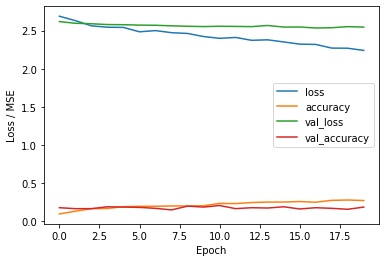

In [109]:
# Train model

estimator = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=128)

# Training history
plt.figure()
plt.ylabel('Loss / MSE')
plt.xlabel('Epoch')
for k in estimator.history.keys():
    plt.plot(estimator.history[k], label = k) 
plt.legend(loc='best')
plt.show()


In [88]:

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #plt.ylim([-0.5, cm.shape[0]-0.5])

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
def make_cm_plot(model,
            inp,
            trg,
            num_classes,
            label='Test data'):
    
    print('\n','#'*10,'Result for {}'.format(label), '#'*10, '\n')

    y = model.predict(inp, verbose=0 )
    print('log_loss:   ', '{:.4f}'.format(log_loss(trg, y, eps=1e-15)))

    d_class = trg.argmax(axis=1)
    y_class = y.argmax(axis=1)
    print('accuracy:   ', '{:.4f}'.format((y_class==d_class).mean()), '\n')

    class_names = ['class {}'.format(i+1) for i in range(num_classes)]
    print(classification_report(d_class, y_class, target_names=class_names))

    confuTst = confusion_matrix(d_class, y_class)
    plot_confusion_matrix(cm           = confuTst, 
                          normalize    = False,
                          target_names = class_names,
                          title        = "Confusion Matrix")



 ########## Result for Training data ########## 



2022-07-19 22:16:05.527592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


log_loss:    0.3561
accuracy:    0.9711 

              precision    recall  f1-score   support

     class 1       0.96      0.87      0.91        77
     class 2       0.97      0.98      0.97        57
     class 3       0.76      1.00      0.87        13
     class 4       1.00      1.00      1.00        27
     class 5       1.00      1.00      1.00        18
     class 6       0.98      1.00      0.99        41
     class 7       1.00      1.00      1.00        19
     class 8       0.95      1.00      0.97        18
     class 9       1.00      1.00      1.00        16
    class 10       0.98      1.00      0.99        40
    class 11       1.00      1.00      1.00        30
    class 12       1.00      1.00      1.00        15
    class 13       1.00      1.00      1.00        27
    class 14       1.00      0.86      0.92        14
    class 15       0.94      1.00      0.97        15
    class 16       1.00      1.00      1.00        23

    accuracy                          

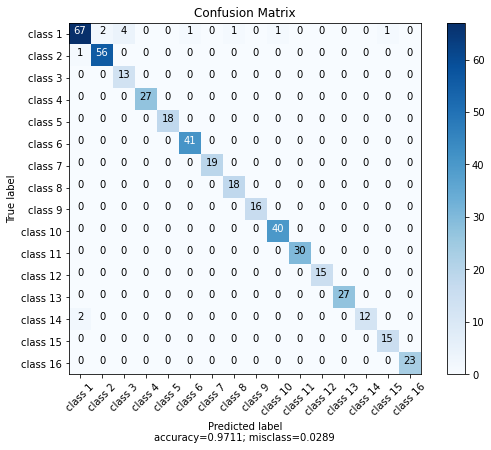

In [104]:
make_cm_plot(model, X_train, y_train, 16, 'Training data')


 ########## Result for Validation data ########## 

log_loss:    2.8562
accuracy:    0.1975 

              precision    recall  f1-score   support

     class 1       0.19      0.37      0.25        43
     class 2       0.25      0.35      0.29        31
     class 3       0.00      0.00      0.00         7
     class 4       0.07      0.07      0.07        14
     class 5       0.25      0.10      0.14        10
     class 6       0.16      0.22      0.18        23
     class 7       0.00      0.00      0.00        10
     class 8       0.14      0.10      0.12        10
     class 9       0.00      0.00      0.00         9
    class 10       0.30      0.48      0.37        21
    class 11       0.43      0.19      0.26        16
    class 12       0.00      0.00      0.00         8
    class 13       0.00      0.00      0.00        14
    class 14       0.00      0.00      0.00         7
    class 15       0.00      0.00      0.00         8
    class 16       0.00      0.00      0

/Users/almaliezenga/Documents/example-pokemon-classifier/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/almaliezenga/Documents/example-pokemon-classifier/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/almaliezenga/Documents/example-pokemon-classifier/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

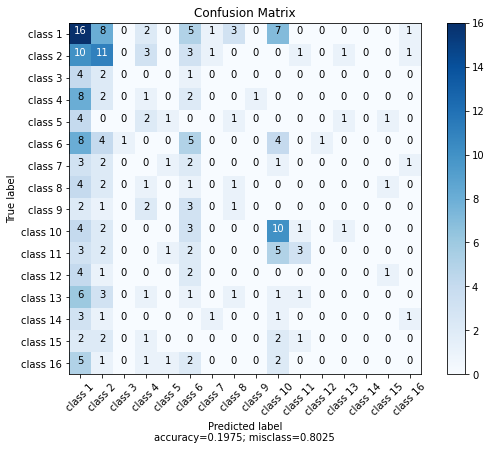

In [105]:
make_cm_plot(model, X_test, y_test, 16, 'Validation data')

1/1 [==============================] - 0s 104ms/step
isSteel (0.296)
isGround (0.114)
isRock (0.0729)


2022-07-19 21:34:27.337715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


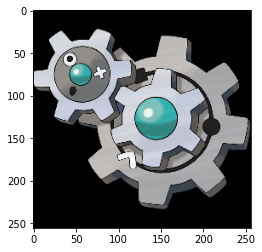

In [45]:
img = tf.keras.utils.load_img('../data/processed/pokemon/600.png',target_size=(256,256,3))
img = tf.keras.utils.img_to_array(img)
img = img/255


classes = np.array(pokemon.columns[5:-1])
proba = model.predict(img.reshape(1,256,256,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)